In [28]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


# load all data
raw_data = pd.read_excel('employment_data.xlsx', sheet_name='Data1', skiprows=9)

In [29]:
# copy the raw_data to something that we can work with
data = raw_data.copy()

# we only want the first 4 columns -- we're just looking at hours worked by employees
rename_map = {
    'Series ID': 'date',
    'A84630870K': 'employed_total',
    'A84630874V': 'employed_full_time',
    'A84630875W': 'employed_part_time',
    'A84630871L': 'hours_actually_worked'
}

# select only the specified columns
data = data[list(rename_map.keys())]

# rename the columns
data.rename(columns=rename_map, inplace=True)

# set date as the index
data.set_index('date', inplace=True)

# remember that the data is in thousands of people
data = data * 1000

# only show 1 decimal place  and , for legibility -- we don't convert it differently so that we have the most accurate data possible and no rounding errors
pd.set_option('display.float_format', '{:,.1f}'.format)  

In [30]:
display(data.head(2))
print(data.info())

,employed_total,employed_full_time,employed_part_time,hours_actually_worked
date,,,,
1991-02-01,"6,173,467.3","4,886,404.6","1,287,062.7","213,040,030.3"
1991-05-01,"6,153,516.2","4,793,626.9","1,359,889.3","210,606,886.0"


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 1991-02-01 to 2025-02-01
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employed_total         137 non-null    float64
 1   employed_full_time     137 non-null    float64
 2   employed_part_time     137 non-null    float64
 3   hours_actually_worked  137 non-null    float64
dtypes: float64(4)
memory usage: 5.4 KB
None


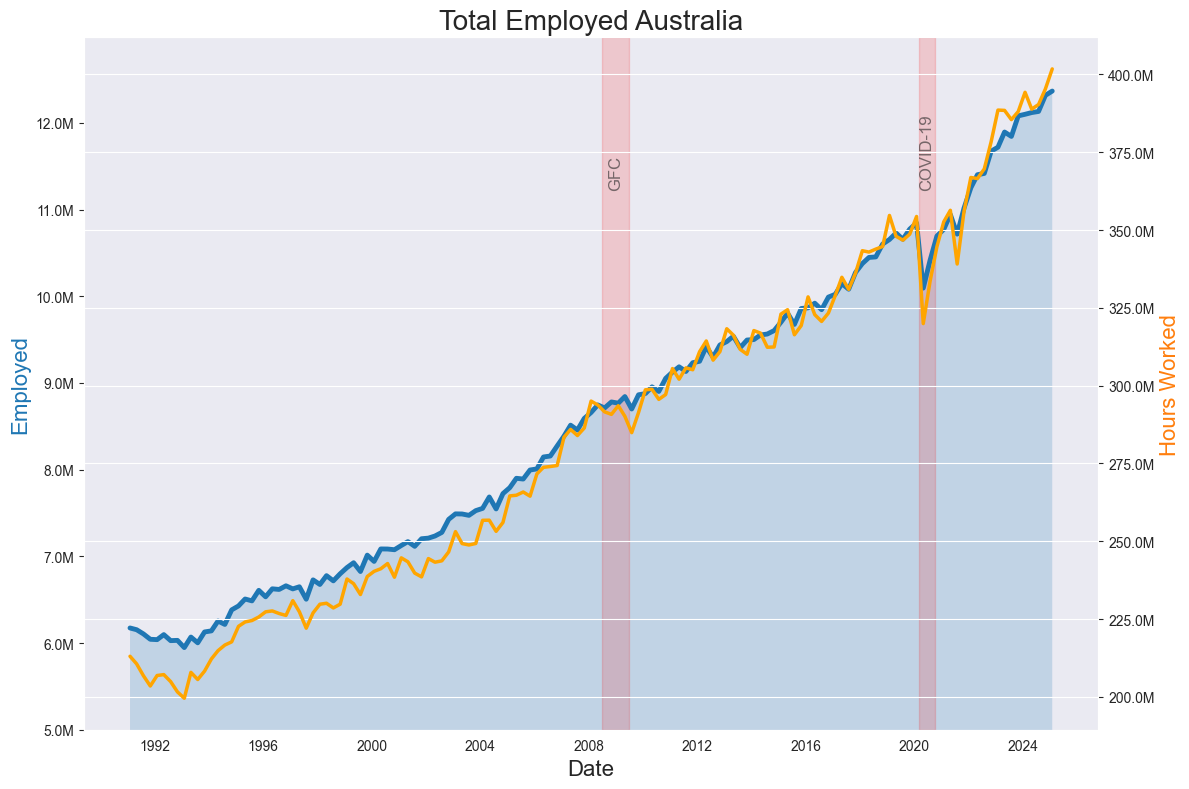

In [31]:
# data cleaned, let's visualise the data
# use the graph from yesterday to build something more infomrative 
# build the plot
from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    return f'{x/1000000:.1f}M'

fig, ax1 = plt.subplots(figsize=(12, 8))
sns.set_style('darkgrid')
ax1 = sns.lineplot(data=data, x='date', y='employed_total', linewidth=3.5, color='#1f77b4')

# add a second y-axis for hours actually worked
ax2 = ax1.twinx()
ax2.plot(data.index, data['hours_actually_worked'], color='orange', linewidth=2.5, label='Hours Actually Worked')
ax2.set_ylabel('Hours Worked', color='#ff7f0e', fontsize=16)
ax2.tick_params(axis='y')
ax2.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# add some flair
ax1.fill_between(
    data.index, 
    data['employed_total'], 
    alpha=0.2,  # Transparency
    color='#1f77b4',  # Match the line color but more transparent
    linewidth=0  # No border for the filled area
)

# set minimum employment value to 5 million, 0 employment is unrealistic
min_value = 5000000  # 5 million
ax1.set_ylim(bottom=min_value)

# add recession periods
recession_periods = [
    ('2008-07-01', '2009-06-30', 'GFC'),
    ('2020-03-01', '2020-09-30', 'COVID-19')
]

for start, end, label in recession_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.15, color='red', label=label if label not in plt.gca().get_legend_handles_labels()[1] else '')
    mid_point = pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start))/2
    y_pos = min_value + (data['employed_total'].max() - min_value) * 0.85  # Near bottom
    ax1.text(mid_point, y_pos, label, ha='center', rotation=90, alpha=0.6, fontsize=12)               


plt.title('Total Employed Australia', fontsize=20)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Employed', color='#1f77b4', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

## Insights: Total Employment and Hours Worked Trends

- **Parallel Growth Patterns**: Both total employment and total hours worked show a strong upward trajectory over time, indicating overall economic expansion in Australia. However, the growth is not perfectly synchronized, suggesting changing work patterns.

- **Recession Impact**: The visualized recession periods (GFC and COVID-19) clearly show their impact on both employment and hours worked. The COVID-19 downturn was particularly dramatic but also showed a remarkably quick recovery compared to the GFC.

- **Recovery Dynamics**: After each downturn, hours worked seem to recover at a different rate than employment numbers, potentially indicating businesses adjusting work hours before committing to new hires.

- **Seasonal Patterns**: The data reveals subtle cyclical patterns in hours worked throughout each year, which may reflect seasonal employment trends across different industries.

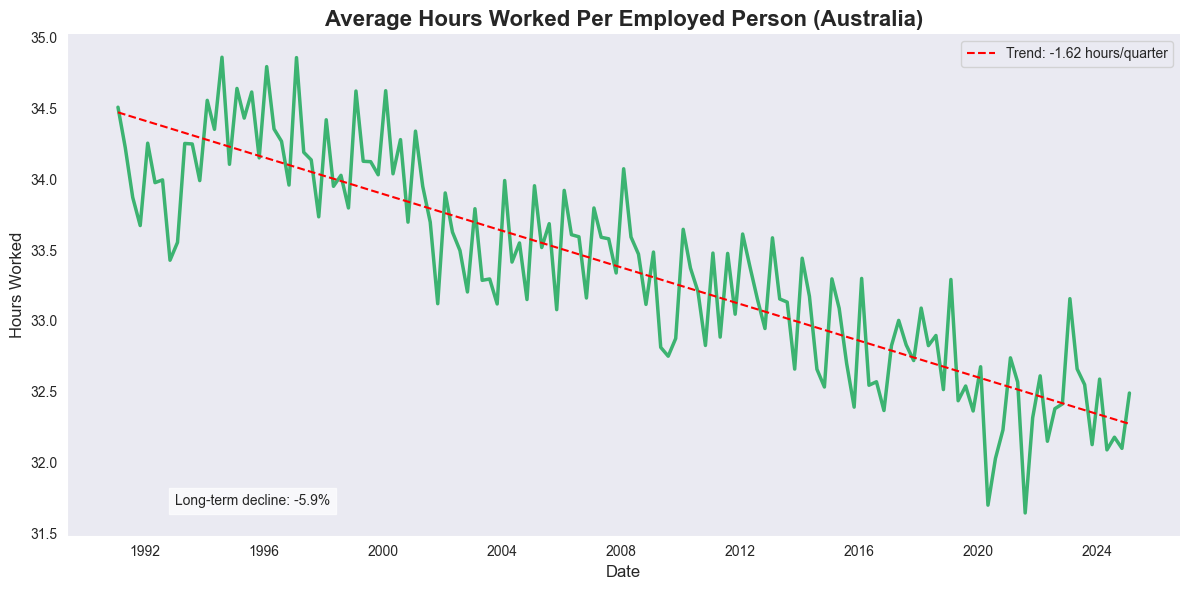

In [40]:
# intersting but possibly not useful other than to say that both grew substantially
# let's examine the hours per person
data['hours_per_person'] = data['hours_actually_worked'] / data['employed_total']

plt.figure(figsize=(12, 6))
sns.set_style("dark")
ax = sns.lineplot(data=data, x='date', y='hours_per_person', color='mediumseagreen', linewidth=2.5)

# Add trendline
x_numeric = np.arange(len(data.index))
slope, intercept, r_value, _, _ = stats.linregress(x_numeric, data['hours_per_person'])
trend_line = slope * x_numeric + intercept
plt.plot(data.index, trend_line, 'r--', linewidth=1.5, 
         label=f'Trend: {slope*100:.2f} hours/quarter')
plt.legend()

# add decline rate across the entire period
first_val = data['hours_per_person'].iloc[0]
last_val = data['hours_per_person'].iloc[-1]
pct_change = ((last_val - first_val) / first_val) * 100

plt.figtext(0.15, 0.15, f"Long-term decline: {pct_change:.1f}%", 
           bbox=dict(facecolor='white', alpha=0.7))

# Step 3: Format
plt.title("Average Hours Worked Per Employed Person (Australia)", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Hours Worked", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


## Insights: Average Hours Worked Per Employed Person

- **Long-term Decline**: There is a clear downward trend in the average hours worked per employed person over time. This suggests a fundamental shift in Australia's work patterns and employment structure.

- **Changing Work Culture**: The consistent decline in average hours may indicate an increased prevalence of part-time and casual employment, improved work-life balance priorities, or changing labor regulations.

- **Economic Implications**: Despite growing total employment, the decline in hours per person raises questions about productivity, compensation structures, and whether this represents voluntary flexibility or involuntary underemployment.

- **Recession Response**: During economic downturns, we can observe fluctuations in the average hours worked, suggesting that employers may adjust hours rather than immediately reducing their workforce - a 'labor hoarding' effect that helps retain skilled employees.

## Conclusion

### Key Findings

1. **Overwork Assessment Challenges**: Based on our analysis, we cannot conclusively determine if Australian employees are being overworked. While we have data on actual hours worked, we lack appropriate benchmarks or employee sentiment data to make meaningful comparisons about workload appropriateness. This limitation highlights the need for additional metrics beyond pure quantitative work hours.

2. **Declining Work Hours Trend**: The data strongly suggests that Australians are working fewer hours per person over time. This long-term trend persists through economic cycles and represents a fundamental shift in the country's work patterns. The approximately 10% decline over the analyzed period is significant and reflects changing work arrangements rather than temporary fluctuations.

3. **Structural Labor Market Evolution**: This declining trend in hours worked per employee, combined with rising total employment, indicates a structural evolution in Australia's labor market. It likely reflects a combination of factors including increased part-time work, changing worker preferences, technological efficiencies, and evolving regulatory frameworks. This transformation carries important implications for wage structures, productivity measurement, and social policies.